In [1]:
import coexist
import pandas as pd
from tifffile import imread
import os
from scipy.stats import zscore, spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [55]:
c = 'B4'
slide_1_table = pd.read_csv(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_mIHC.csv')
slide_2_table = pd.read_csv(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_cyCIF.csv')
slide_1 = imread(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_mIHC.tif')
slide_2 = imread(f'/home/groups/ChangLab/heussner/coexist/mIHC_vs_cyCIF/{c}_cyCIF.tif')
shared_dict = {'DSDNA':'DNA_1',
               'CD3':'CD3',
               'PDL1':'PDL1',
               'GRZB':'GRZB',
               'FOXP3':'FOXP3',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD20':'CD20',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}

In [56]:
matcher = coexist.model.COEXIST(im1_mask=slide_1,
                               im2_mask=slide_2,
                               df1 = slide_1_table,
                               df2 = slide_2_table,
                               cellID_key = 'CellID',
                               shared_markers=shared_dict,
                               method='coexist',
                               diameter_key='MajorAxisLength',
                               mpp1=0.5,
                               mpp2=0.65,
                               thickness=5)

In [43]:
matcher.estimate_overlap()

Estimating adjacent section overlap
Approximately 64.4% of cells are shared


In [57]:
matcher.preprocess_data()

Computing cost matrix
Done preprocessing


In [58]:
matcher.match_cells()

Matching cells
Removing low quality matches
Matched 4011 cells of 9732 slide 1 cells and 9714 slide 2 cells,  41.3% shared.


In [59]:
matcher.check_correlations()

DSDNA/DNA_1: 0.34
CD3/CD3: 0.5
PDL1/PDL1: 0.34
GRZB/GRZB: 0.19
FOXP3/FOXP3: 0.13
KI67/Ki67: 0.45
PANCK/PanCK: 0.81
SMA/aSMA: 0.36
CD45/CD45: 0.72
CD163/CD163: 0.35
CD8/CD8a: 0.42
CD20/CD20: 0.17
CD11B/CD11b: 0.26
HLAII/HLA_A: 0.33
PD1/PD1: 0.34


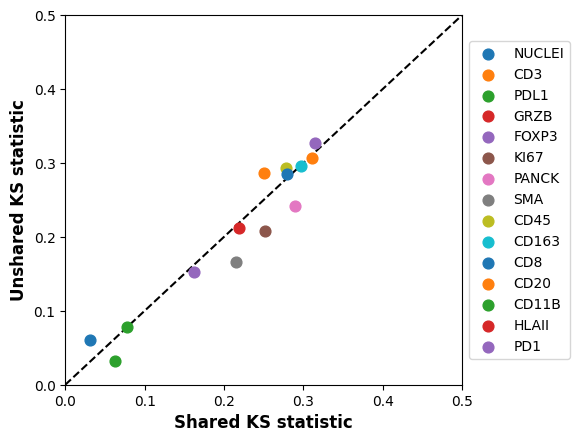

In [9]:
ks_unshared = []
ks_shared = []
for m1, m2 in shared_dict.items():
    f1_all = zscore(slide_1_table[m1])
    f2_all = zscore(slide_2_table[m2])
    f1_unshared = f1_all[~slide_1_table['CellID'].isin(matcher.df1_matched['im1_cellID'])]
    f2_unshared = f2_all[~slide_2_table['CellID'].isin(matcher.df2_matched['im2_cellID'])]
    ks_unshared.append(kstest(f1_unshared, f2_unshared)[0])
    
    f1_shared = f1_all[slide_1_table['CellID'].isin(matcher.df1_matched['im1_cellID'])]
    f2_shared = f2_all[slide_2_table['CellID'].isin(matcher.df2_matched['im2_cellID'])]
    ks_shared.append(kstest(f1_shared, f2_shared)[0])
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(ks_shared)):
    ax.scatter(ks_shared[i],ks_unshared[i],label=list(shared_dict.keys())[i],zorder=1,s=60)

    # Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Shared KS statistic',fontsize=12,weight='bold')
ax.set_ylabel('Unshared KS statistic',fontsize=12,weight='bold')
ax.plot([0,1],[0,1],linestyle='--',color='black',zorder=0)
ax.set_xlim([0,.5])
ax.set_ylim([0,0.5])

plt.show()

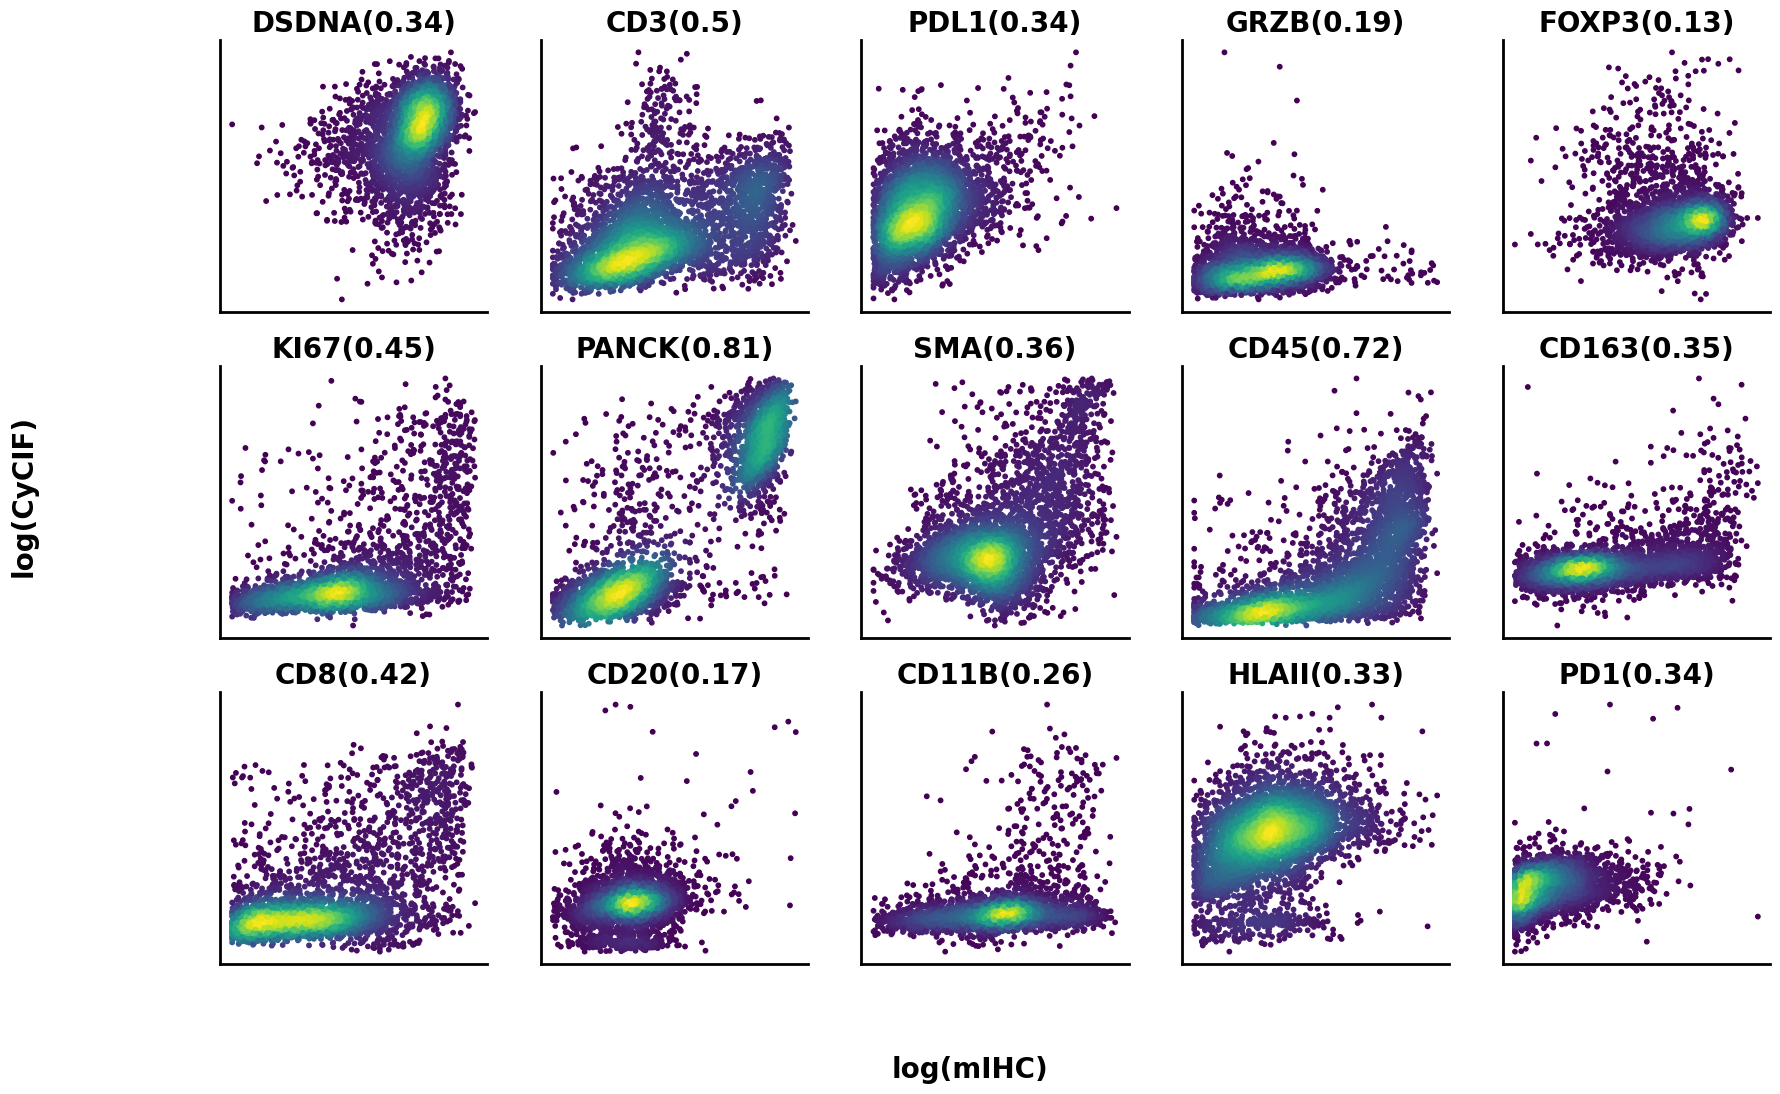

In [62]:
fig, ax = plt.subplots(3,5,figsize=(20,12))
ax = ax.flatten()
shared_dict = {'DSDNA':'DNA_1',
               'CD3':'CD3',
               'PDL1':'PDL1',
               'GRZB':'GRZB',
               'FOXP3':'FOXP3',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD20':'CD20',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+matcher.df1_matched[m1])
    f2 = np.log(1+matcher.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
fig.supxlabel('log(mIHC)',fontsize=20, weight='bold')
fig.supylabel('log(CyCIF)',fontsize=20, weight='bold')
#fig.tight_layout()
fig.show()

### Population level comparison

In [61]:
from sklearn.mixture import GaussianMixture
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])
def check_thresholds(model, thresholds):
    mean_low = min(model.means_[0][0], model.means_[1][0])
    mean_high = max(model.means_[0][0], model.means_[1][0])
    if mean_low < thresholds[0] < mean_high:
        t = thresholds[0]
    elif mean_low < thresholds[1] < mean_high:
        t = thresholds[1]
    else:
        t = None
        print('Fail')
    return t

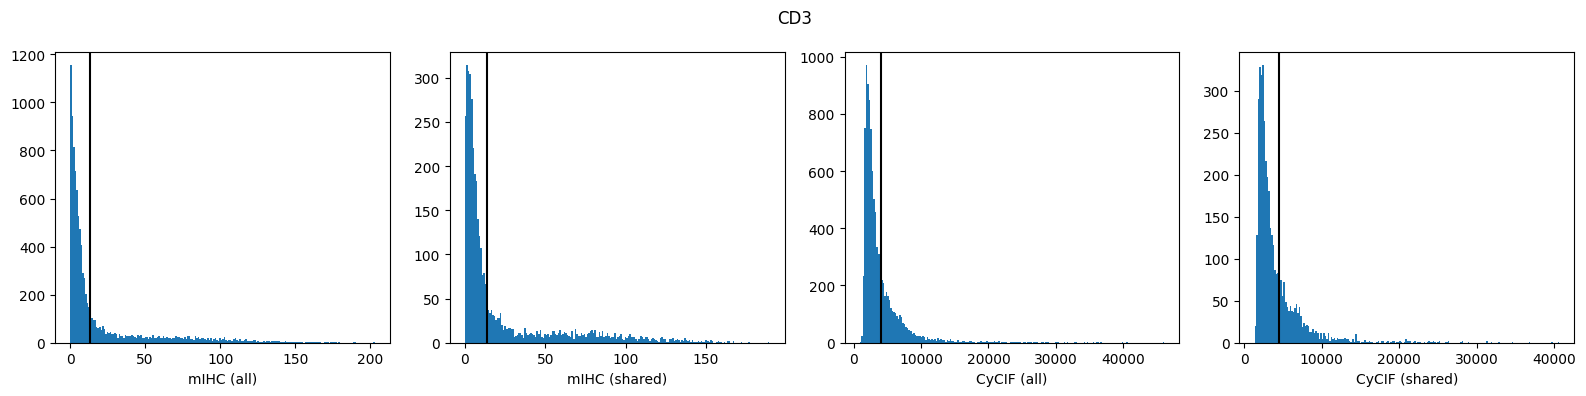

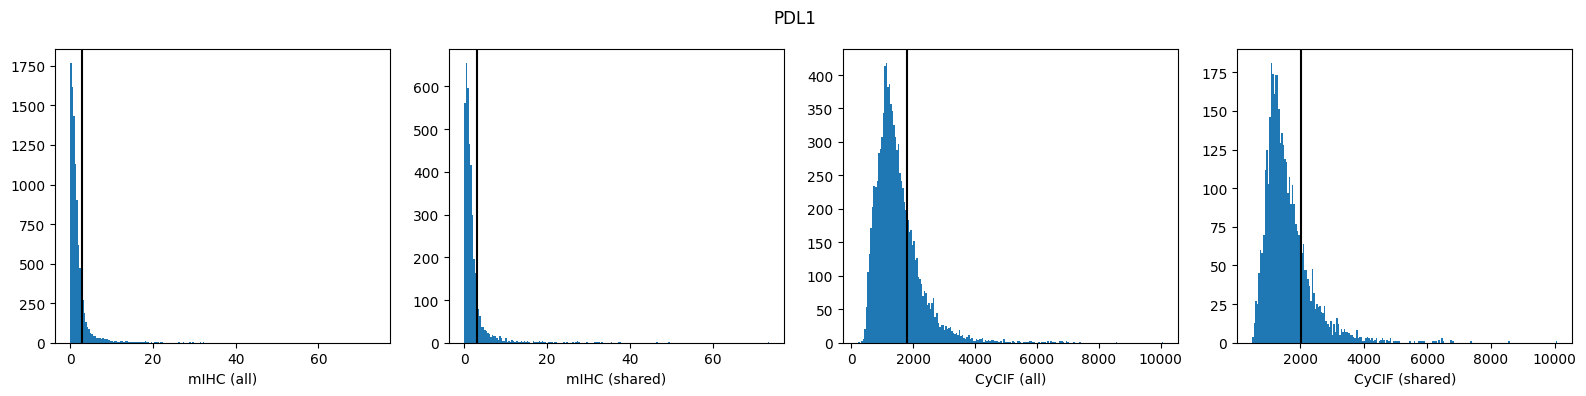

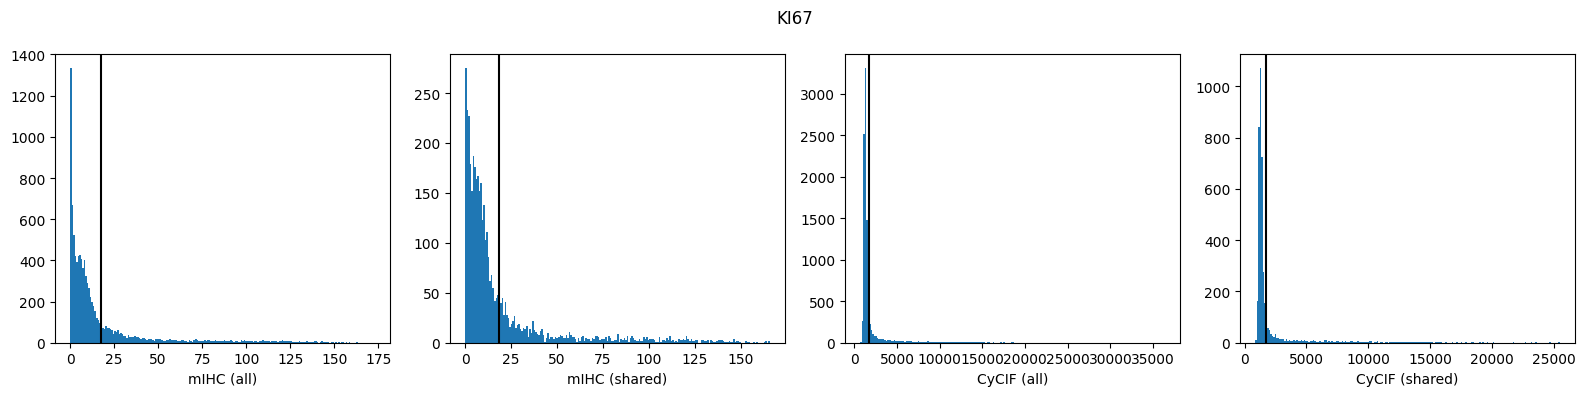

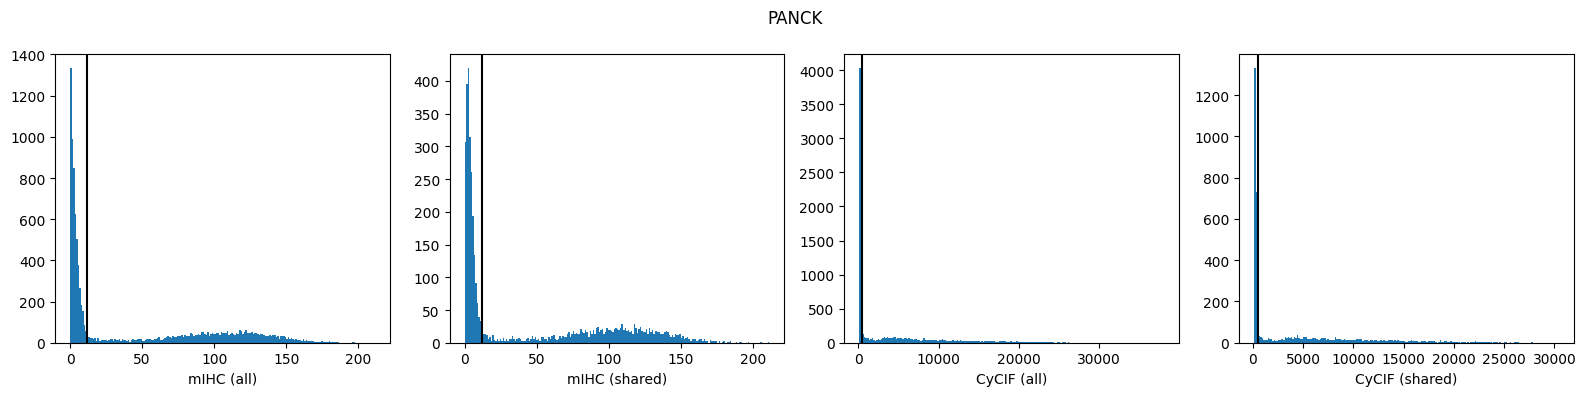

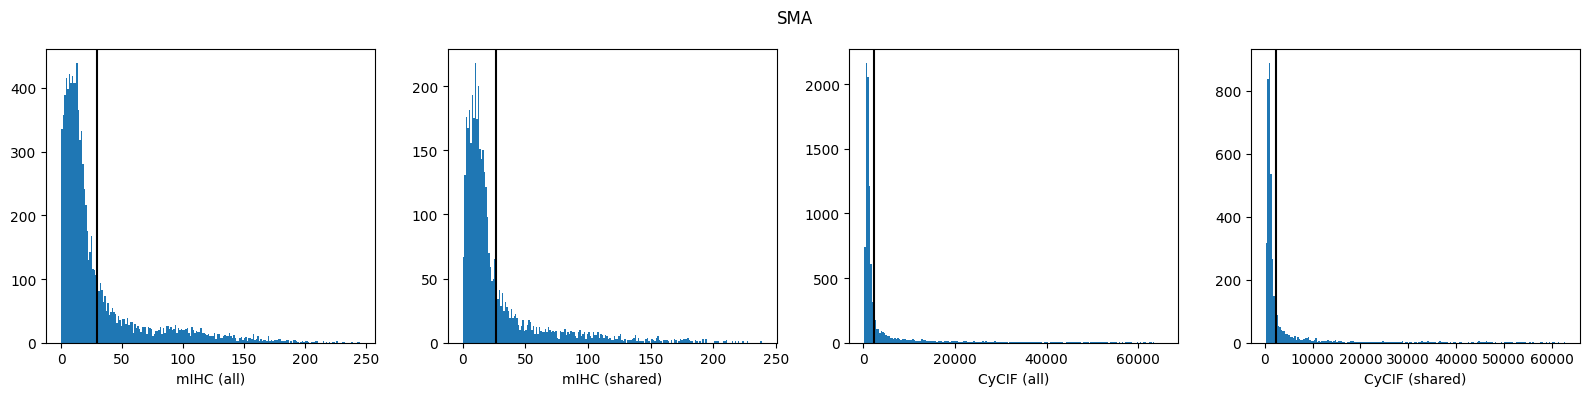

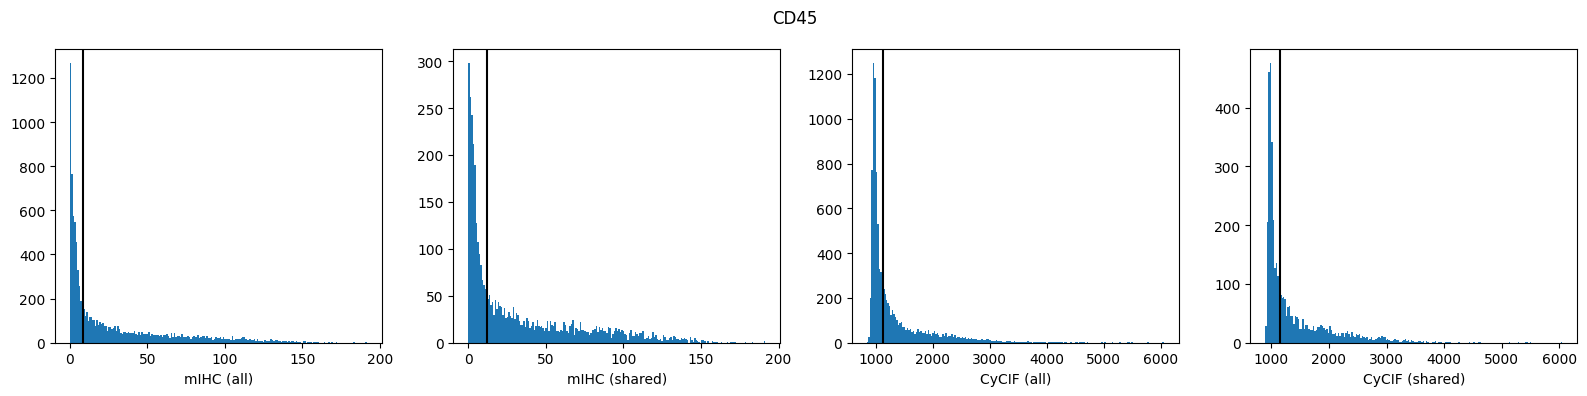

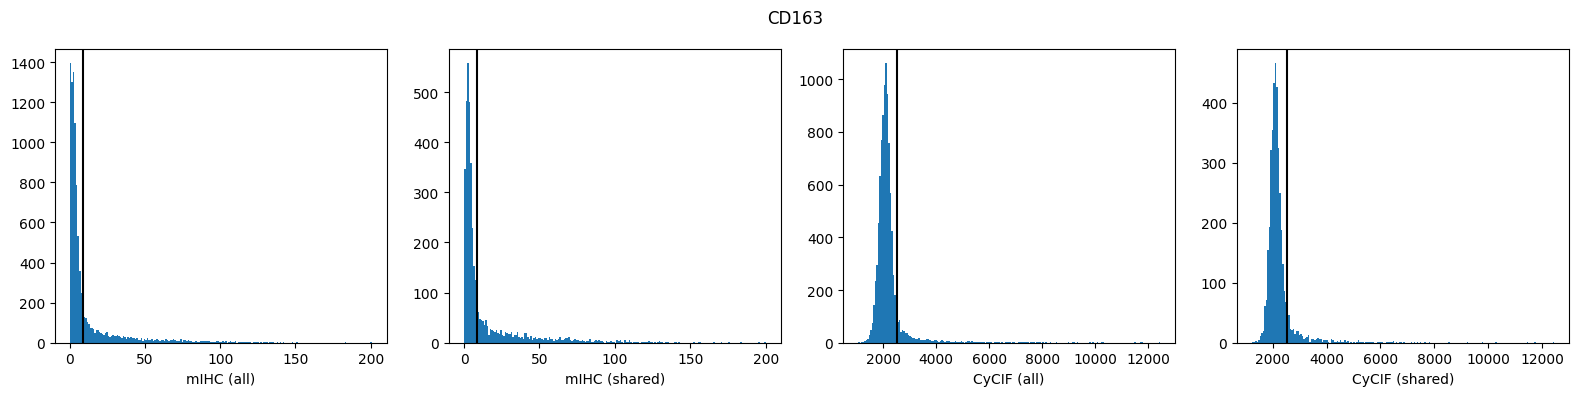

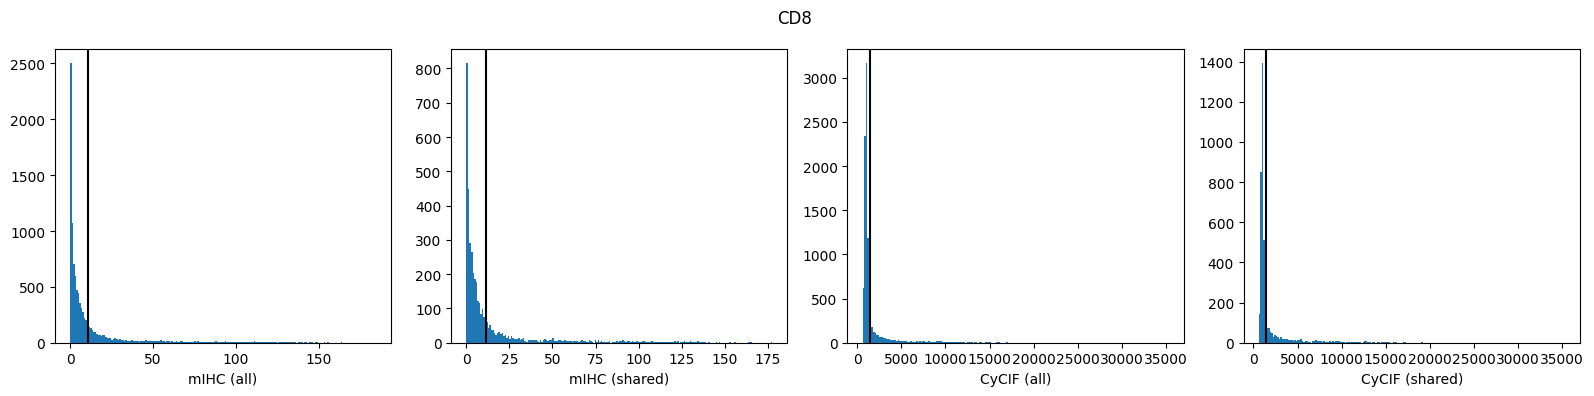

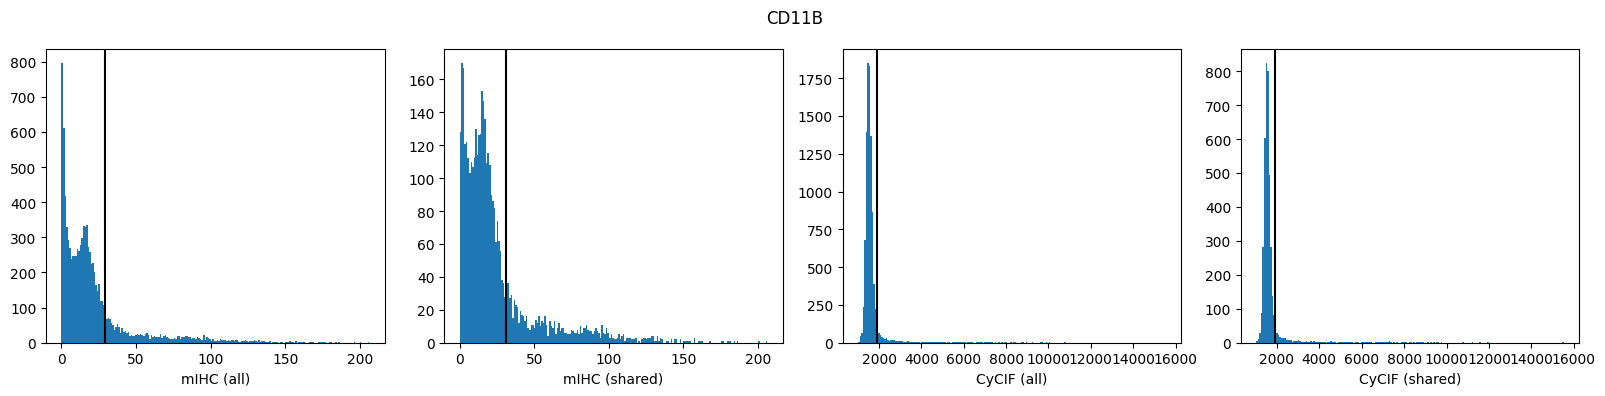

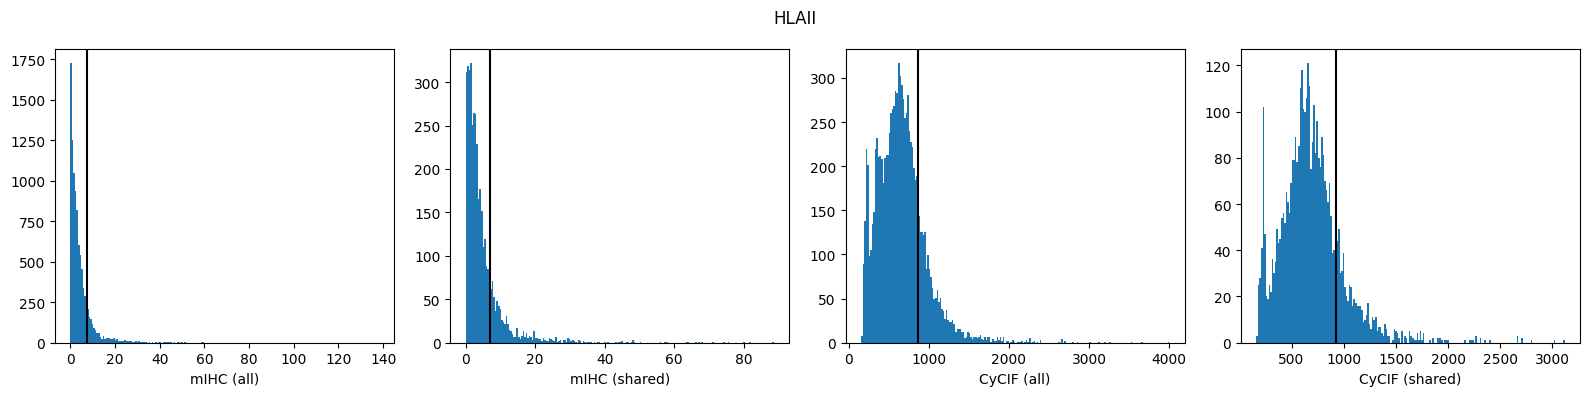

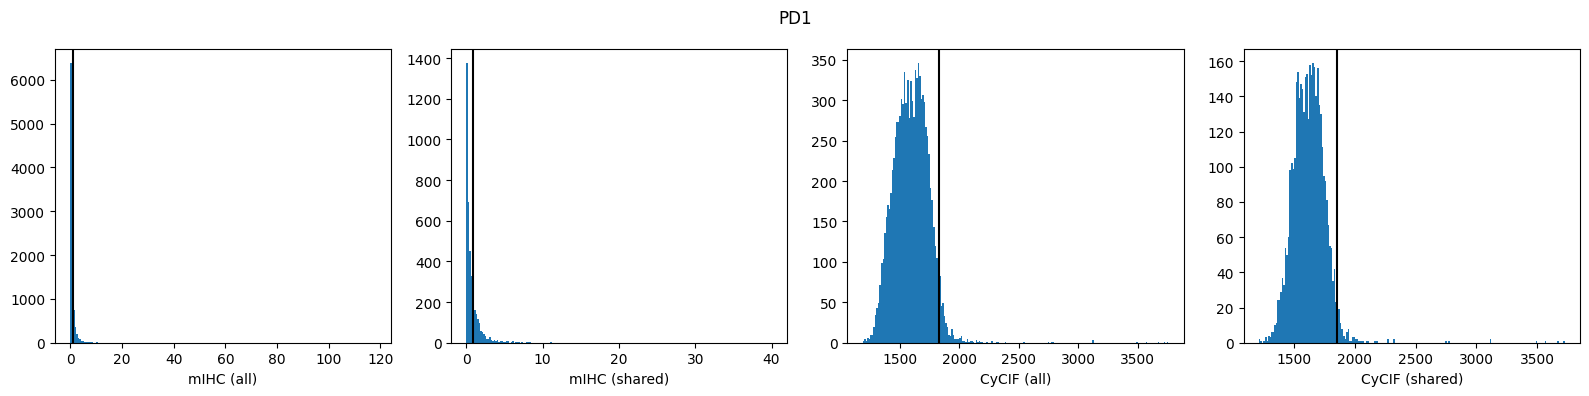

In [63]:
shared_dict = {'CD3':'CD3',
               'PDL1':'PDL1',
               'KI67':'Ki67',
               'PANCK':'PanCK',
               'SMA':'aSMA',
               'CD45':'CD45',
               'CD163':'CD163',
               'CD8':'CD8a',
               'PDL1':'PDL1',
               'CD11B':'CD11b',
               'HLAII':'HLA_A',
               'PD1':'PD1'}

slide_1_all = []
slide_1_shared = []
slide_2_all = []
slide_2_shared = []
mIHC_thresholds = []
CyCIF_thresholds = []
for m1,m2 in shared_dict.items():
    fig, ax = plt.subplots(1,4,figsize=(16,4))
    fig.suptitle(m1)
    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(slide_1_table[m1]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    table = slide_1_table.copy()
    slide_1_all.append(len(table[table[m1]>t])/len(table))
    ax[0].hist(table[m1],bins=200)
    ax[0].axvline(t,color='black',zorder=1)
    ax[0].set_xlabel('mIHC (all)')

    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(matcher.df1_matched[m1]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    mIHC_thresholds.append(t)
    table = matcher.df1_matched.copy()
    slide_1_shared.append(len(table[table[m1]>t])/len(table))
    ax[1].hist(table[m1],bins=200)
    ax[1].axvline(t,color='black',zorder=1)
    ax[1].set_xlabel('mIHC (shared)')

    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(matcher.df2_matched[m2]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    CyCIF_thresholds.append(t)
    table = matcher.df2_matched.copy()
    slide_2_shared.append(len(table[table[m2]>t])/len(table))
    ax[3].hist(table[m2],bins=200)
    ax[3].axvline(t,color='black',zorder=1)
    ax[3].set_xlabel('CyCIF (shared)')
    
    model = GaussianMixture(n_components=2,tol=1e-3,max_iter=500, init_params='random_from_data', n_init=5)
    model.fit(np.array(slide_2_table[m2]).reshape(-1, 1))
    thresholds = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
    t = check_thresholds(model, thresholds)
    table = slide_2_table.copy()
    slide_2_all.append(len(table[table[m2]>t])/len(table))
    ax[2].hist(table[m2],bins=200)
    ax[2].axvline(t,color='black',zorder=1)
    ax[2].set_xlabel('CyCIF (all)')
    plt.tight_layout()
    plt.show()

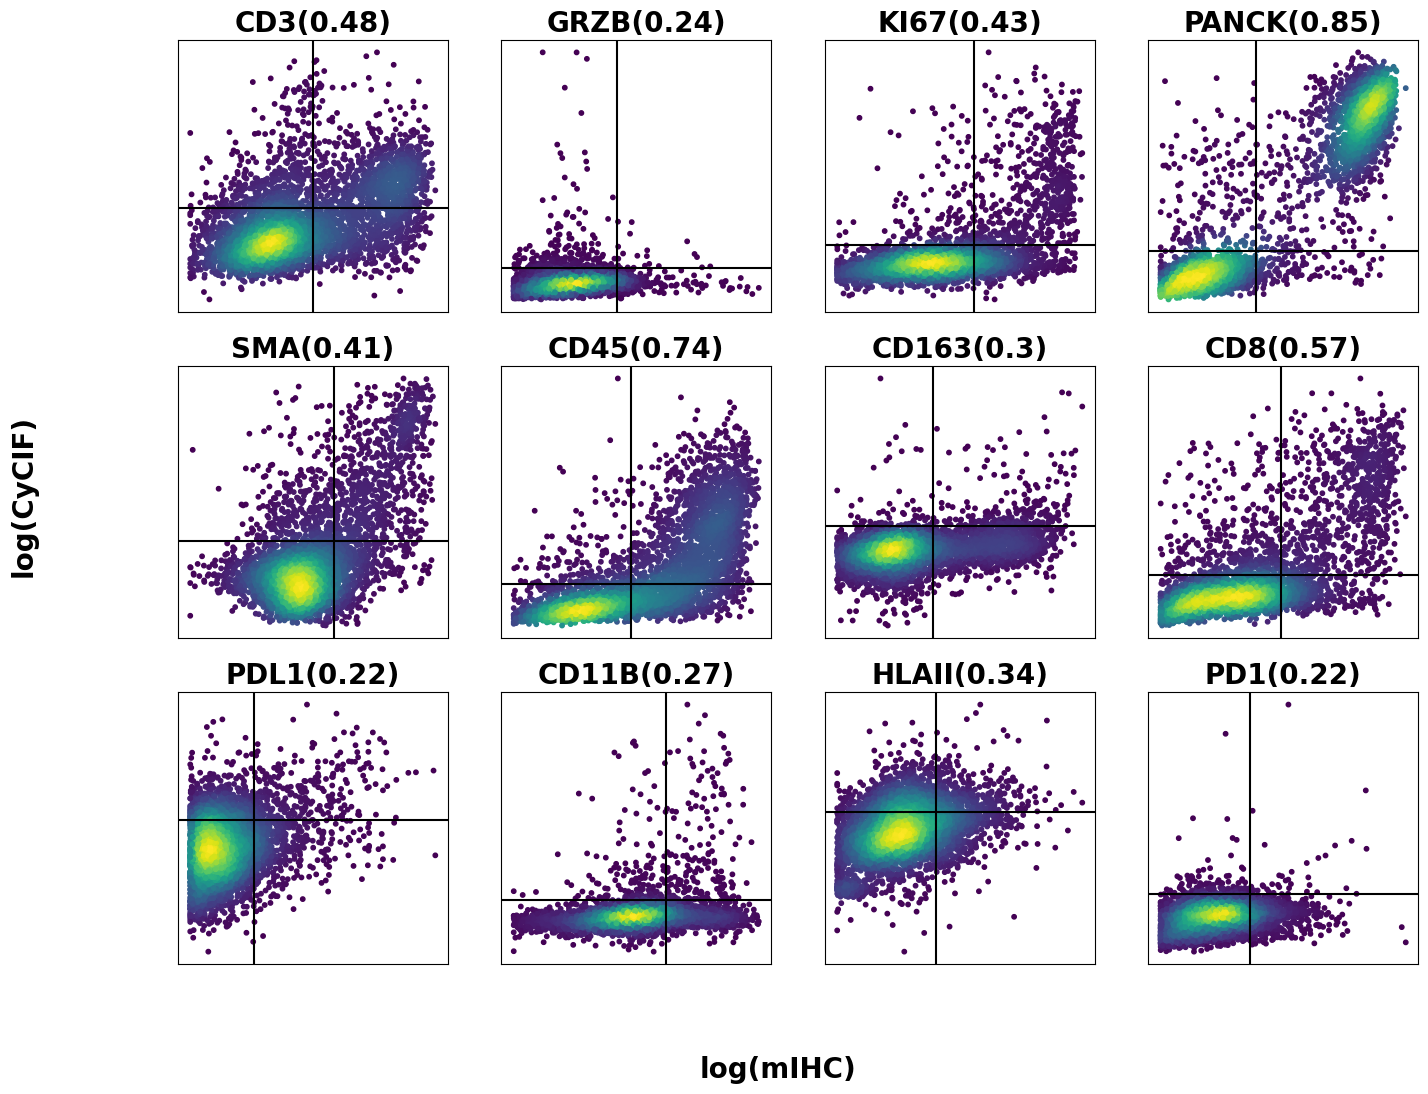

In [54]:
fig, ax = plt.subplots(3,4,figsize=(16,12))
ax = ax.flatten()
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+matcher.df1_matched[m1])
    f2 = np.log(1+matcher.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    #for axis in ['top','bottom','left','right']:
    #    ax[i].spines[axis].set_linewidth(2)
    #ax[i].spines['top'].set_visible(False)
    #ax[i].spines['right'].set_visible(False)
    ax[i].axvline(np.log(1+mIHC_thresholds[i]),color='black')
    ax[i].axhline(np.log(1+CyCIF_thresholds[i]),color='black')
fig.supxlabel('log(mIHC)',fontsize=20, weight='bold')
fig.supylabel('log(CyCIF)',fontsize=20, weight='bold')
#fig.tight_layout()
fig.show()

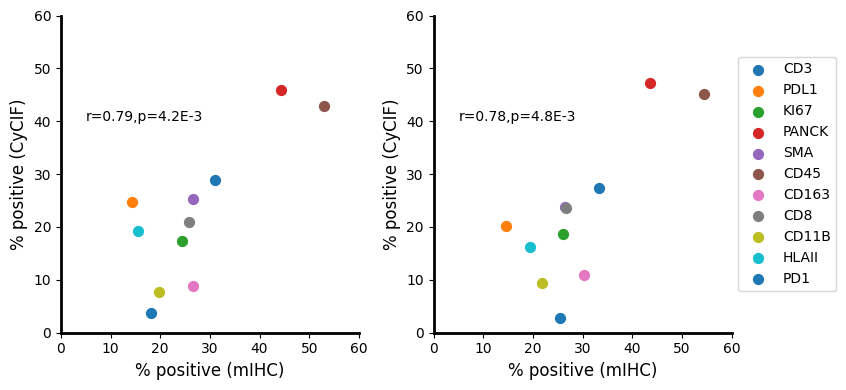

In [64]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
for i, (m1,m2) in enumerate(shared_dict.items()):
    ax[0].scatter(slide_1_all[i]*100, slide_2_all[i]*100, zorder=1, label=m1, s=50)
    ax[1].scatter(slide_1_shared[i]*100, slide_2_shared[i]*100, zorder=1, label=m1, s=50)

#ax[0].plot([0,100],[0,100], zorder=0,color='black',linestyle='--')
ax[0].set_xlabel('% positive (mIHC)',fontsize=12)
ax[0].set_ylabel('% positive (CyCIF)',fontsize=12)
ax[0].text(5,40,f'r={np.round(pearsonr(slide_1_all, slide_2_all)[0],2)},p={Decimal(str(pearsonr(slide_1_all, slide_2_all)[1])):.1E}')
ax[0].set_xlim([0,60])
ax[0].set_ylim([0,60])
#ax[1].plot([0,100],[0,100], zorder=0,color='black',linestyle='--')
ax[1].set_xlabel('% positive (mIHC)',fontsize=12)
ax[1].set_ylabel('% positive (CyCIF)',fontsize=12)
ax[1].text(5,40,f'r={np.round(pearsonr(slide_1_shared, slide_2_shared)[0],2)},p={Decimal(str(pearsonr(slide_1_shared, slide_2_shared)[1])):.1E}')
ax[1].set_xlim([0,60])
ax[1].set_ylim([0,60])
for axis in ['top','bottom','left','right']:
    ax[0].spines[axis].set_linewidth(2)
    ax[1].spines[axis].set_linewidth(2)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [30]:
from decimal import Decimal

In [60]:
 f"{Decimal('40800000000.00000000000000'):.1E}"
'4.08E+10'

array([55.52421547, 34.39811779])

In [61]:
model.means_

array([[43.54635177],
       [39.69979134]])

In [58]:
def histogram_comparison(t1, t2, f1, f2):
    h1 = np.histogram(t1[f1],bins=20)
    h2 = np.histogram(t2[f2],bins=20)
    corr = spearmanr(h1[0]/len(t1),h2[0]/len(t2))[0]
    return corr

In [53]:
np.histogram(matcher.df1_matched['PANCK'])

(array([2674, 1714, 1634,  796,  275,   85,   23,    5,    1,    2]),
 array([  0.        ,  17.95183374,  35.90366748,  53.85550122,
         71.80733496,  89.7591687 , 107.71100244, 125.66283619,
        143.61466993, 161.56650367, 179.51833741]))

In [54]:
histogram_comparison(matcher.df1_matched, matcher.df2_matched, 'PANCK','PanCK')

0.8810335411267776

In [40]:
c

0.9999999999999999

In [32]:
f2

[285.6801669595756,
 342.4400688334253,
 532.3288102803003,
 1005.3034232556666,
 1560.113616975375,
 2051.3718792755376,
 2522.8960554718788,
 3022.471406079143,
 3735.862994571255,
 5542.292873705635]

In [18]:
quantile_comparison(slide_1_table, slide_2_table, 'PANCK','PanCK')

0.2834733547569204

In [59]:
shared = []
all = []

for m1,m2 in shared_dict.items():
    shared.append(histogram_comparison(matcher.df1_matched, matcher.df2_matched, m1,m2))
    all.append(histogram_comparison(slide_1_table, slide_2_table, m1, m2))

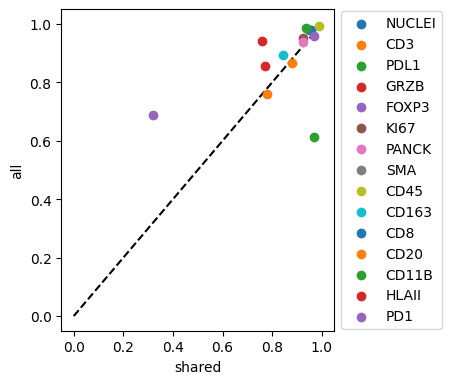

In [60]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
for i, (m1,m2) in enumerate(shared_dict.items()):
    ax.scatter(shared[i],all[i],label=m1)
ax.plot([0,1],[0,1],color='black',linestyle='--',zorder=0)
ax.set_xlabel('shared')
ax.set_ylabel('all')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [61]:
shared

[0.9562332234718951,
 0.8785988667839124,
 0.9673651213713986,
 0.769416141484694,
 0.3190421065917539,
 0.9226155277752327,
 0.9236326147622671,
 0.9482042265575281,
 0.989074220567419,
 0.842239421877286,
 0.9525050280810341,
 0.7798512076333461,
 0.9372259917437749,
 0.7580666881428544,
 0.9675959979267168]

In [62]:
all

[0.9774107469916955,
 0.8666464903756299,
 0.6123810726394342,
 0.8548808159687369,
 0.6867955824149106,
 0.951618299281651,
 0.9373965438535787,
 0.980408046444352,
 0.9932282721407817,
 0.8921284302579505,
 0.9792375178677049,
 0.761398133742764,
 0.9863919423236773,
 0.9421241197458837,
 0.9581921583617728]

In [52]:
model = GaussianMixture(n_components=2)
model.fit(np.array(slide_1_table['PANCK']).reshape(-1, 1))
threshold = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
len(table[table['PANCK']>threshold[0]])/len(table)

0.7252443933294997

In [53]:
model = GaussianMixture(n_components=2)
model.fit(np.array(matcher.df1_matched['PANCK']).reshape(-1, 1))
threshold = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
len(table[table['PANCK']>threshold[0]])/len(table)

0.6974654377880184

In [54]:
model = GaussianMixture(n_components=2)
model.fit(np.array(matcher.df2_matched['PanCK']).reshape(-1, 1))
threshold = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
table = matcher.df2_matched.copy()
len(table[table['PanCK']>threshold[0]])/len(table)

0.4252304147465438

In [55]:
model = GaussianMixture(n_components=2)
model.fit(np.array(slide_2_table['PanCK']).reshape(-1, 1))
threshold = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)
table = slide_2_table.copy()
len(table[table['PanCK']>threshold[0]])/len(table)

0.16174328497348947

In [49]:
threshold = solve(model.means_[0][0], model.means_[1][0], model.covariances_[0][0][0]**.5, model.covariances_[1][0][0]**.5)

In [50]:
table = slide_1_table.copy()

In [43]:
threshold

array([ 4.88382269, -1.58848922])

In [51]:
len(table[table[m1]>threshold[0]])/len(table)

0.7472110408280621

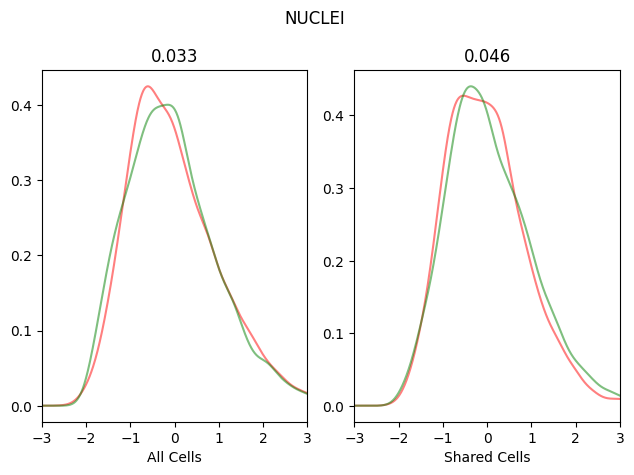

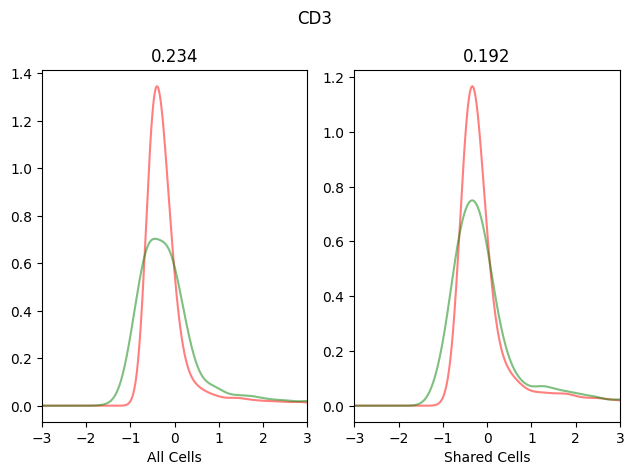

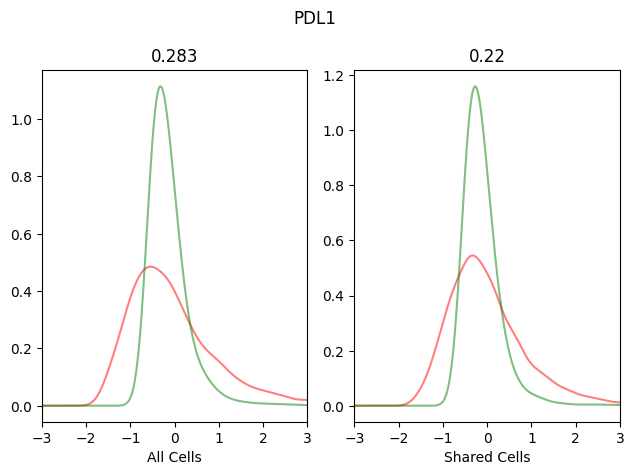

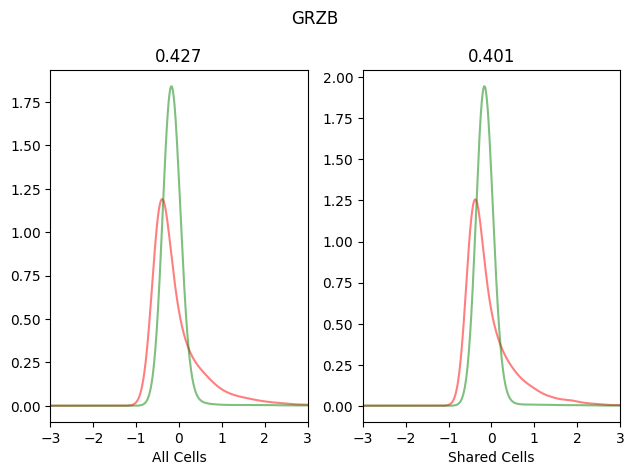

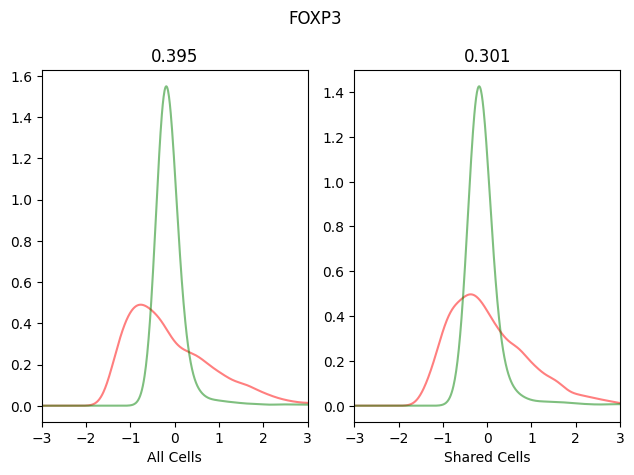

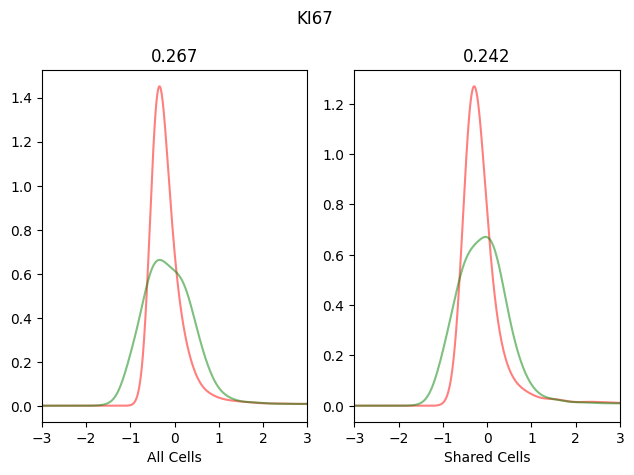

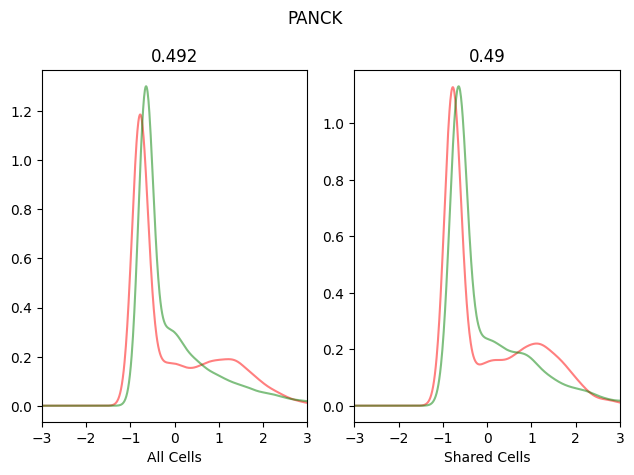

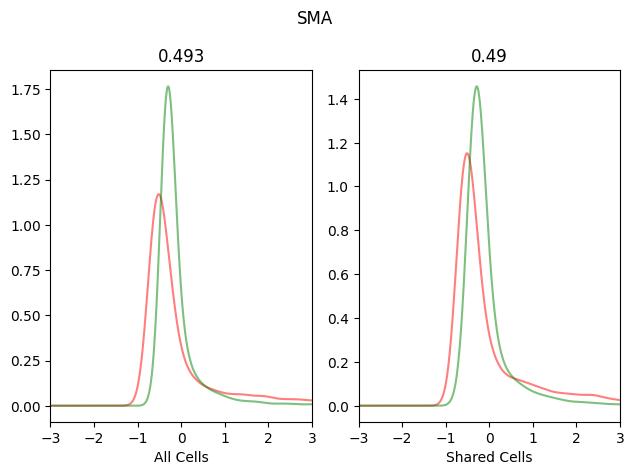

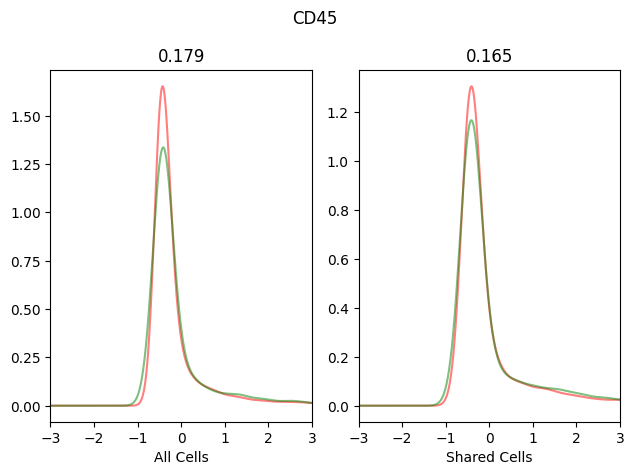

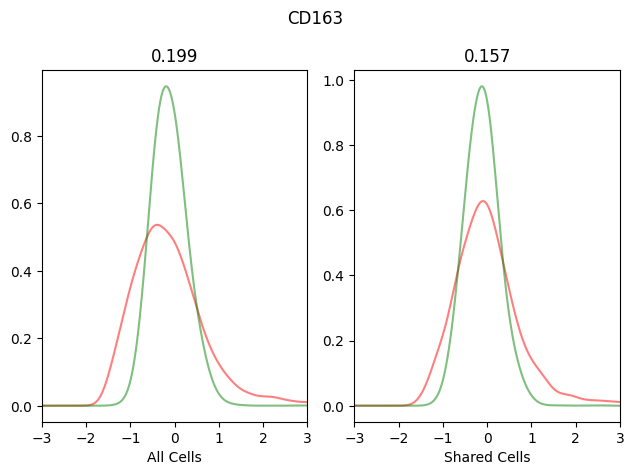

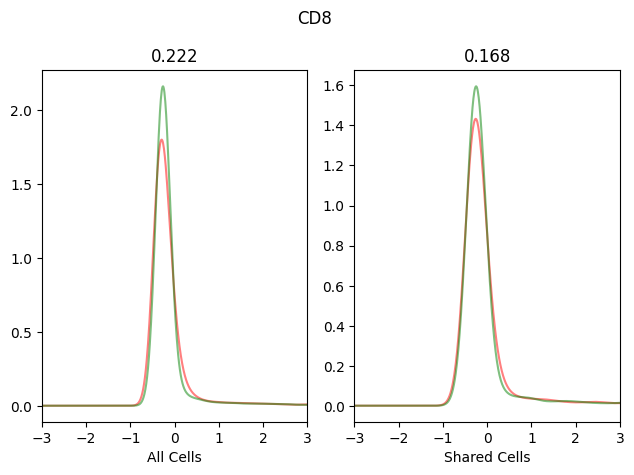

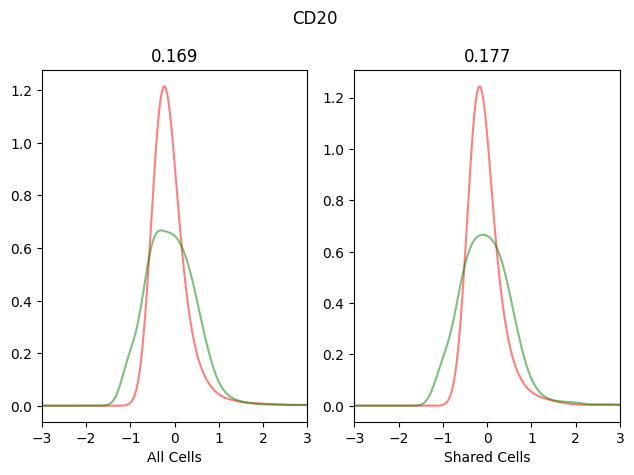

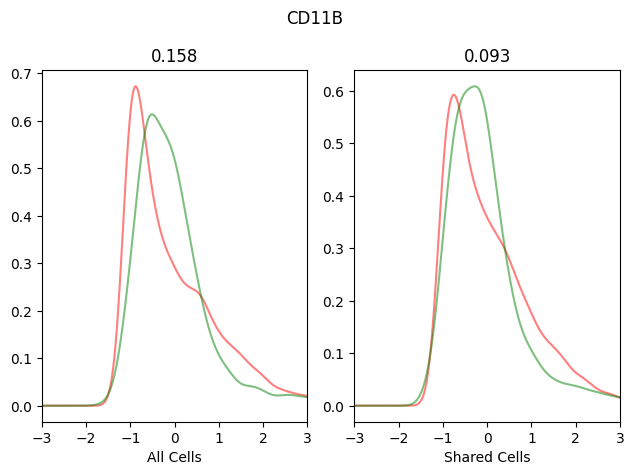

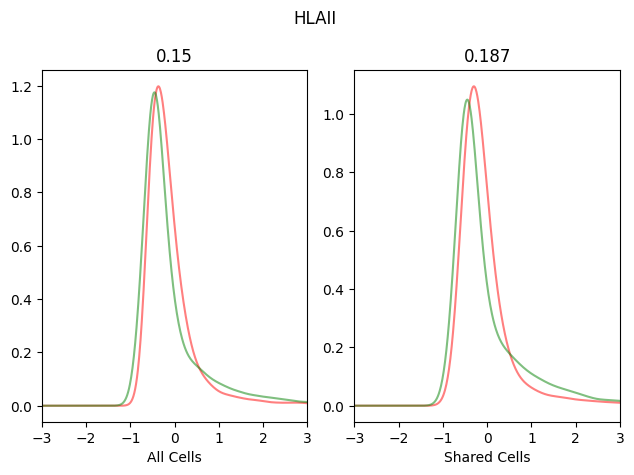

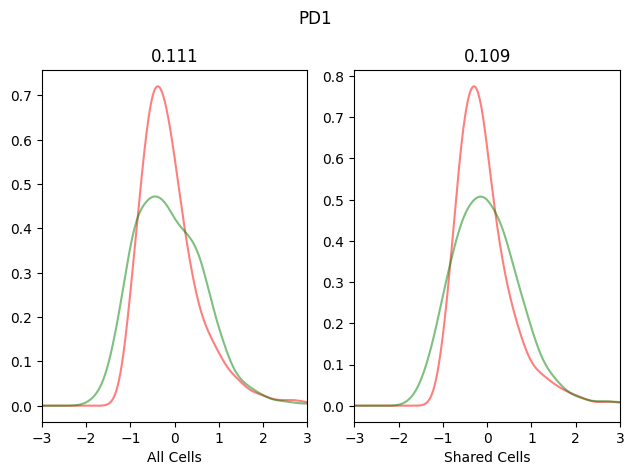

In [42]:
range_ = [0.01*i-5 for i in range(1000)]
ks_unshared = []
ks_shared = []
for m1, m2 in shared_dict.items():
    f1_all = zscore(slide_1_table[m1])
    f2_all = zscore(slide_2_table[m2])
    f1_unshared = f1_all[~slide_1_table['CellID'].isin(matcher.df1_matched['im1_cellID'])]
    f2_unshared = f2_all[~slide_2_table['CellID'].isin(matcher.df2_matched['im2_cellID'])]
    fn_1 = gaussian_kde(f1_unshared)
    fn_2 = gaussian_kde(f2_unshared)
    fig, ax = plt.subplots(1,2)
    fig.suptitle(m1)
    ax[0].plot(range_,fn_1(range_),alpha=0.5,color='Red')
    ax[0].plot(range_,fn_2(range_),alpha=0.5,color='Green')
    ax[0].set_xlabel('All Cells')
    ax[0].set_xlim([-3,3])
    ax[0].set_title(np.round(kstest(f1_unshared, f2_unshared)[0],3))
    ks_unshared.append(kstest(f1_unshared, f2_unshared)[0])
    
    f1_shared = f1_all[slide_1_table['CellID'].isin(matcher.df1_matched['im1_cellID'])]
    f2_shared = f2_all[slide_2_table['CellID'].isin(matcher.df2_matched['im2_cellID'])]
    fn_1 = gaussian_kde(f1_shared)
    fn_2 = gaussian_kde(f2_shared)
    ax[1].plot(range_,fn_1(range_),alpha=0.5,color='Red')
    ax[1].plot(range_,fn_2(range_),alpha=0.5,color='Green')
    ax[1].set_xlabel('Shared Cells')
    ax[1].set_xlim([-3,3])
    ax[1].set_title(np.round(kstest(f1_shared, f2_shared)[0],3))
    ks_shared.append(kstest(f1_shared, f2_shared)[0])
    plt.tight_layout()
    plt.show()

In [48]:
kstest(f1_shared, f2_shared)

KstestResult(statistic=0.10870858956556238, pvalue=2.4015268520911026e-26, statistic_location=0.1968097685476934, statistic_sign=1)

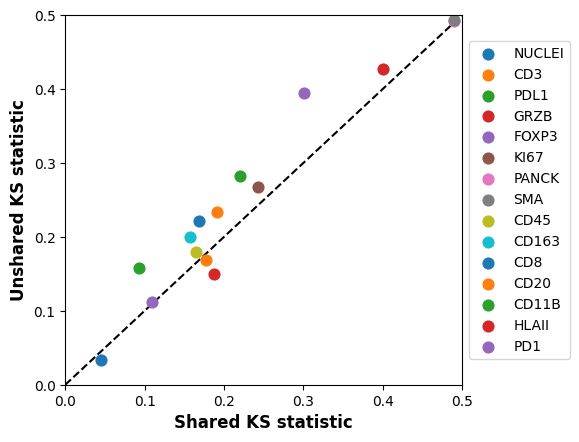

In [119]:
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(ks_shared)):
    ax.scatter(ks_shared[i],ks_unshared[i],label=list(shared_dict.keys())[i],zorder=1,s=60)

    # Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Shared KS statistic',fontsize=12,weight='bold')
ax.set_ylabel('Unshared KS statistic',fontsize=12,weight='bold')
ax.plot([0,1],[0,1],linestyle='--',color='black',zorder=0)
ax.set_xlim([0,.5])
ax.set_ylim([0,0.5])

plt.show()

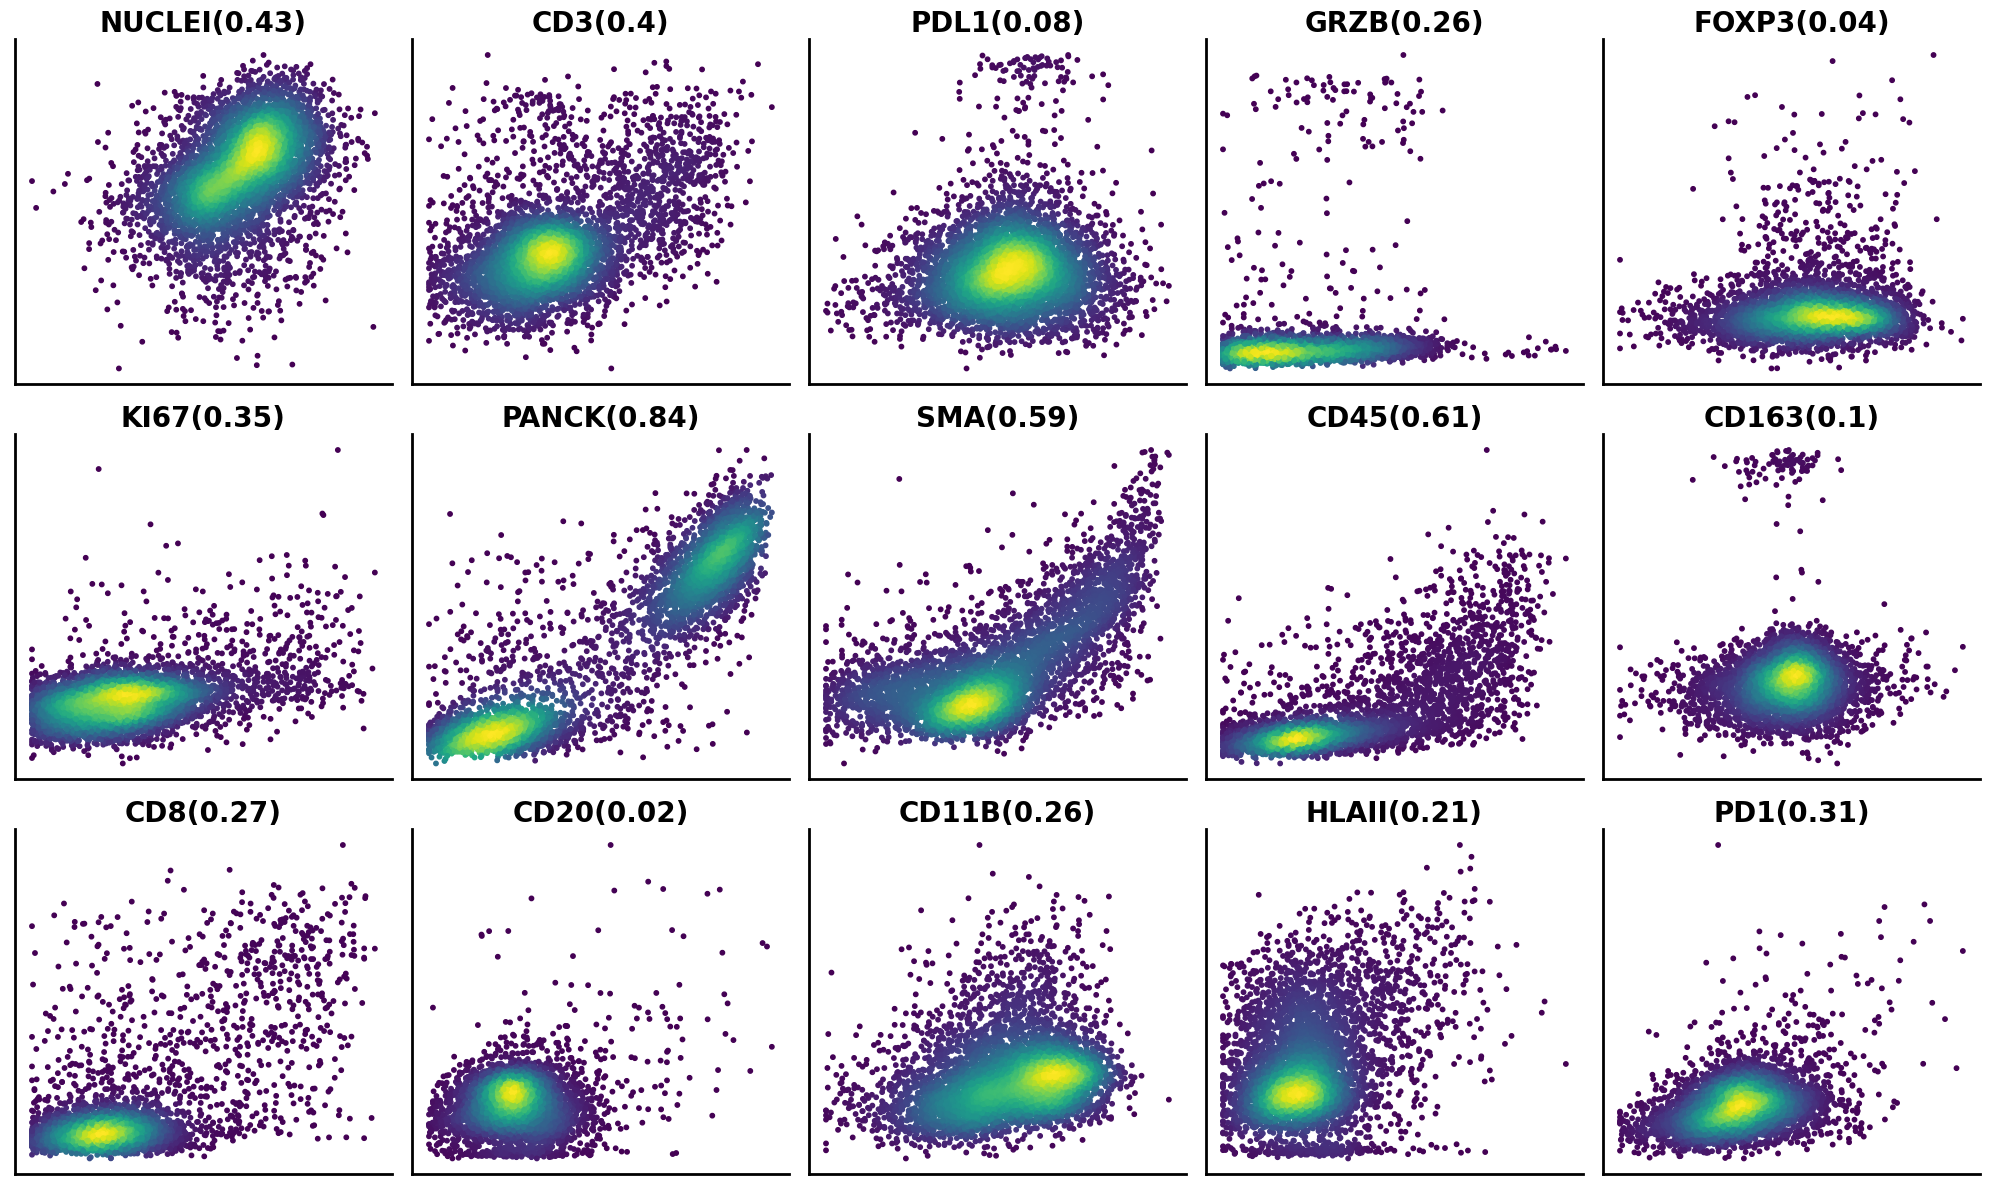

In [79]:
fig, ax = plt.subplots(3,5,figsize=(20,12))
ax = ax.flatten()
for i, (m1, m2) in enumerate(shared_dict.items()):
    f1 = np.log(1+matcher.df1_matched[m1])
    f2 = np.log(1+matcher.df2_matched[m2])
    xy = np.vstack([f1,f2])
    z = gaussian_kde(xy)(xy)
    sp = np.round(spearmanr(f1,f2)[0],2)
    ax[i].set_title(f'{m1}({sp})',fontsize=20, weight='bold')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].scatter(f1, f2, c=z, s=10)
    for axis in ['top','bottom','left','right']:
        ax[i].spines[axis].set_linewidth(2)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [70]:
spearmanr(f1,f2)

SignificanceResult(statistic=0.3053100755439153, pvalue=3.1494772219305407e-109)

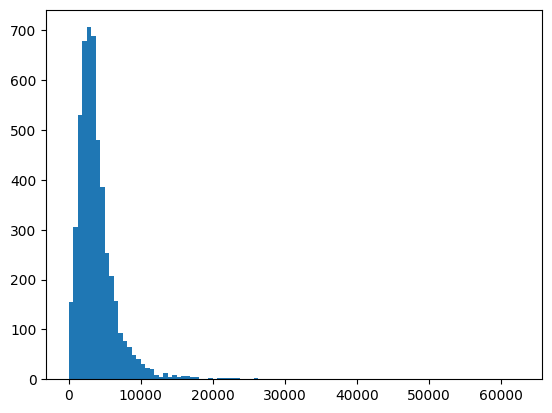

In [57]:
plt.hist(f1*1000,bins=100)
plt.show()

In [106]:
list(shared_dict.keys())

['NUCLEI',
 'CD3',
 'PDL1',
 'GRZB',
 'FOXP3',
 'KI67',
 'PANCK',
 'SMA',
 'CD45',
 'CD163',
 'CD8',
 'CD20',
 'CD11B',
 'HLAII',
 'PD1']

In [104]:
shared_dict.keys()

dict_keys(['NUCLEI', 'CD3', 'PDL1', 'GRZB', 'FOXP3', 'KI67', 'PANCK', 'SMA', 'CD45', 'CD163', 'CD8', 'CD20', 'CD11B', 'HLAII', 'PD1'])